In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, FloatType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col
from pyspark.ml.clustering import LDA
import gensim
from gensim.models import CoherenceModel

In [2]:
spark = SparkSession.builder \
           .appName('Tuning LDA Model') \
           .config("spark.jars", "mysql-connector-j-8.0.32.jar")\
           .config("spark.driver.memory", "6g") \
           .config("spark.executor.memory", "8g") \
           .getOrCreate()

In [3]:
data = spark.read \
            .format("jdbc") \
            .option("driver","com.mysql.cj.jdbc.Driver") \
            .option("url", "jdbc:mysql://web-database/Web") \
            .option("dbtable", "redditData") \
            .option("user", "root") \
            .option("password", "123") \
            .load() 
data.count()

3973

In [4]:
data = data.select('id', 'category', 'descriptions')
data = data.dropna(subset = ('category'))

## For Business topic

In [5]:
business_data = data.filter(col('category') == 'Business')
business_data.count()

238

In [6]:
preprocessed_business_df = preprocessing(business_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_business_df)
wordVectors_business = vectorizer.transform(preprocessed_business_df)

In [7]:
wordVectors_business.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
| 17|Business|Do companies unde...|[do, company, und...|[company, underst...|(1160,[24,206,241...|
| 21|Business|Five cool project...|[five, cool, proj...|[five, cool, proj...|(1160,[26,69,259,...|
| 28|Business|Vice Media files ...|[vice, media, fil...|[vice, media, fil...|(1160,[103,201,54...|
| 35|Business|Wells Fargo reach...|[well, fargo, rea...|[well, fargo, rea...|(1160,[6,147,200,...|
| 44|Business|Consumer debt pas...|[consumer, debt, ...|[consumer, debt, ...|(1160,[2,15,59,62...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



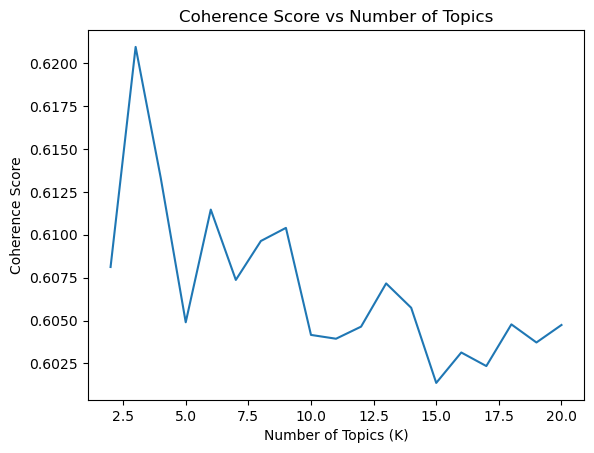

In [11]:
corpus = wordVectors_business.select("filtered").rdd.flatMap(lambda x: x[0]).collect()
texts = [text.split() for text in corpus]
dictionary = gensim.corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]

coherence_scores = []
for k in range(2, 21):
    lda = LDA(k = k, maxIter = 100, featuresCol = 'features', seed = 2)
    model = lda.fit(wordVectors_business)

    topics = model.describeTopics()
    topic_words = topics.select("termIndices").rdd.map(lambda x: x[0]).collect()
    topic_words = [[dictionary[idx] for idx in indices] for indices in topic_words]

    coherence_model = CoherenceModel(topics = topic_words, texts = texts, dictionary = dictionary)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
plt.plot(range(2, 21), coherence_scores)
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

=> K = 3

In [12]:
lda = LDA(k = 3, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_business)
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
say: 0.013014042597095767
business: 0.012752787532436773
bank: 0.009039296001029642
us: 0.008474194355766039
market: 0.007883805922916943
new: 0.007801623456453936
rise: 0.005892542774432604
chinese: 0.005728795920000832
win: 0.005723834595455195
world: 0.005633935023626596

Topic ID: 1
Top Words:
debt: 0.014029317820626861
business: 0.010107818810761789
ceiling: 0.009932406710661373
unitedstates: 0.0092725058042278
billion: 0.008892545195141445
get: 0.007932290625944497
know: 0.007023670458754732
account: 0.007011968256466268
loan: 0.006368592180151846
raise: 0.005692348350252327

Topic ID: 2
Top Words:
price: 0.008146824505439477
year: 0.006144774604014812
rat: 0.006025035067353128
sales: 0.005765010198218069
grow: 0.005638844683310471
april: 0.005545188966337968
retail: 0.005535992257839411
uk: 0.005301456455087214
recession: 0.005252337725024455
lawsuit: 0.00515347748737528



## For Sci/Tech topic

In [13]:
tech_data = data.filter(col('category') == 'Sci/Tech')
tech_data.count()

1167

In [14]:
preprocessed_tech_df = preprocessing(tech_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_tech_df)
wordVectors_tech = vectorizer.transform(preprocessed_tech_df)

In [15]:
wordVectors_tech.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  6|Sci/Tech|Why we need a "Ma...|[why, we, need, a...|[need, manhattan,...|(3397,[83,101,128...|
|  7|Sci/Tech|Bird Buddy introd...|[bird, buddy, int...|[bird, buddy, int...|(3397,[0,8,386,94...|
| 10|Sci/Tech|TikTok content cr...|[tiktok, content,...|[tiktok, content,...|(3397,[15,16,27,6...|
| 11|Sci/Tech|NASA picks Blue O...|[nasa, pick, blue...|[nasa, pick, blue...|(3397,[7,69,216,2...|
| 14|Sci/Tech|Italy earmarks $M...|[italy, earmark, ...|[italy, earmark, ...|(3397,[0,65,100,1...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



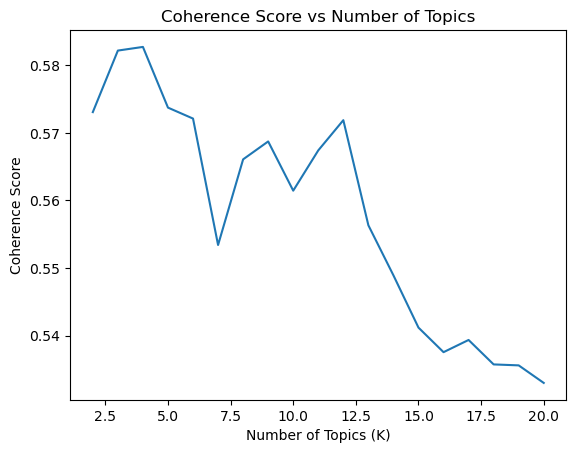

In [16]:
corpus = wordVectors_tech.select("filtered").rdd.flatMap(lambda x: x[0]).collect()
texts = [text.split() for text in corpus]
dictionary = gensim.corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]

coherence_scores = []
for k in range(2, 21):
    lda = LDA(k = k, maxIter = 100, featuresCol = 'features', seed = 2)
    model = lda.fit(wordVectors_tech)

    topics = model.describeTopics()
    topic_words = topics.select("termIndices").rdd.map(lambda x: x[0]).collect()
    topic_words = [[dictionary[idx] for idx in indices] for indices in topic_words]

    coherence_model = CoherenceModel(topics = topic_words, texts = texts, dictionary = dictionary)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
plt.plot(range(2, 21), coherence_scores)
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

=> K = 4

In [19]:
lda = LDA(k = 4, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_tech)
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
ai: 0.021309165455834153
new: 0.01229337522210146
say: 0.01079030394205249
use: 0.008693527554627463
us: 0.007540990938802787
chatgpt: 0.007079350474805647
reddit: 0.006265478012753482
tech: 0.006110350396499516
make: 0.005685223768764338
get: 0.005045530775867273

Topic ID: 1
Top Words:
share: 0.008261144254269622
intelligence: 0.006629203569337049
netflix: 0.006531023604429637
password: 0.0062268313812159
artificial: 0.00552521519194876
microsoft: 0.0054436227663176165
unitedstates: 0.005325095399896878
crackdown: 0.005161618723786789
sue: 0.004300277451560427
like: 0.004061275619437894

Topic ID: 2
Top Words:
apple: 0.021047609209866407
vision: 0.009269806182838116
pro: 0.009085219980198839
headset: 0.007596838693638872
game: 0.007593913729343766
users: 0.007455229970324682
tiktok: 0.006699972534354886
data: 0.005966048391910722
twitter: 0.005618356897154636
musk: 0.005041478900053579

Topic ID: 3
Top Words:
solar: 0.013399407919565676
china: 0.009566199628233

## For Sports topic

In [20]:
sports_data = data.filter(col('category') == 'Sports')
sports_data.count()

320

In [21]:
preprocessed_sports_df = preprocessing(sports_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_sports_df)
wordVectors_sports = vectorizer.transform(preprocessed_sports_df)

In [22]:
wordVectors_sports.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  1|  Sports|Josh Harris group...|[josh, harris, gr...|[josh, harris, gr...|(1522,[214,221,29...|
|  3|  Sports|France withdraw f...|[france, withdraw...|[france, withdraw...|(1522,[3,9,16,86,...|
| 13|  Sports|Everything for wr...|[everything, for,...|[everything, wres...|(1522,[34,260,458...|
| 18|  Sports|Russia, Belarus h...|[russia, belarus,...|[russia, belarus,...|(1522,[72,149,521...|
| 25|  Sports|Florida Panthers ...|[florida, panther...|[florida, panther...|(1522,[8,14,24,31...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



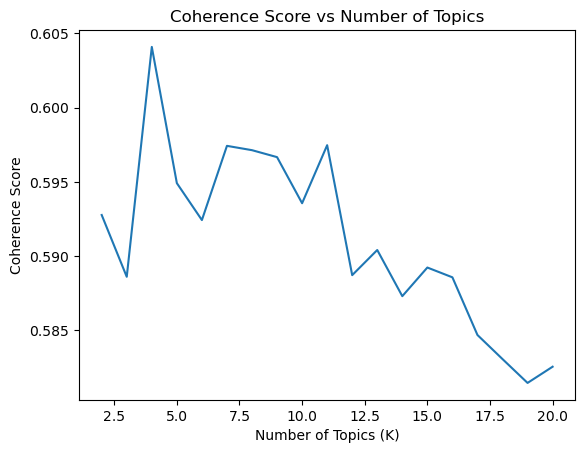

In [23]:
corpus = wordVectors_sports.select("filtered").rdd.flatMap(lambda x: x[0]).collect()
texts = [text.split() for text in corpus]
dictionary = gensim.corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]

coherence_scores = []
for k in range(2, 21):
    lda = LDA(k = k, maxIter = 100, featuresCol = 'features', seed = 2)
    model = lda.fit(wordVectors_sports)

    topics = model.describeTopics()
    topic_words = topics.select("termIndices").rdd.map(lambda x: x[0]).collect()
    topic_words = [[dictionary[idx] for idx in indices] for indices in topic_words]

    coherence_model = CoherenceModel(topics = topic_words, texts = texts, dictionary = dictionary)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
plt.plot(range(2, 21), coherence_scores)
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

=> K = 4

In [24]:
lda = LDA(k = 4, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_sports)
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
game: 0.017423240896223546
win: 0.015827590278671973
final: 0.012377241927892225
league: 0.011853721404008727
nba: 0.009832652651027892
city: 0.00738991811621208
cup: 0.007343758528185536
champion: 0.006623760517144411
manchester: 0.006353332732207506
first: 0.0061906079506292705

Topic ID: 1
Top Words:
ncaa: 0.011781166510861753
win: 0.009730349129258435
record: 0.008397519130070826
championship: 0.007970085161253054
olympic: 0.007588948585516042
women: 0.0069088621496504795
world: 0.00638454318438829
national: 0.00624179540463598
president: 0.0050719511265363395
give: 0.0047371936757865905

Topic ID: 2
Top Words:
messi: 0.010415727579899815
sport: 0.008609173615131796
miami: 0.008567592319569193
team: 0.00850001924039644
nfl: 0.0083415664464762
inter: 0.007830472848668512
end: 0.007547195271833752
new: 0.006927985688159624
use: 0.006833808084964526
rugby: 0.006317724521493864

Topic ID: 3
Top Words:
open: 0.01600363847689274
french: 0.013704607320072656
win: 0.

## For World topic

In [25]:
world_data = data.filter(col('category') == 'World')
world_data.count()

2248

In [26]:
preprocessed_world_df = preprocessing(world_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_world_df)
wordVectors_world = vectorizer.transform(preprocessed_world_df)

In [27]:
wordVectors_world.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  2|   World|China opposes G m...|[china, oppose, g...|[china, oppose, g...|(4697,[5,38,55,20...|
|  4|   World|Montreal group su...|[montreal, group,...|[montreal, group,...|(4697,[25,32,51,2...|
|  5|   World|Assad shakes hand...|[assad, shake, ha...|[assad, shake, ha...|(4697,[33,309,455...|
|  8|   World|Data indicates fa...|[data, indicate, ...|[data, indicate, ...|(4697,[168,341,43...|
|  9|   World|Bionic technology...|[bionic, technolo...|[bionic, technolo...|(4697,[230,265,45...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



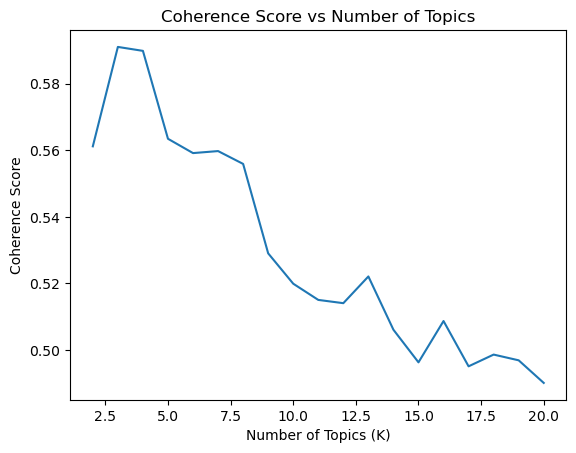

In [28]:
corpus = wordVectors_world.select("filtered").rdd.flatMap(lambda x: x[0]).collect()
texts = [text.split() for text in corpus]
dictionary = gensim.corpora.Dictionary(texts)
corpus_gensim = [dictionary.doc2bow(text) for text in texts]

coherence_scores = []
for k in range(2, 21):
    lda = LDA(k = k, maxIter = 100, featuresCol = 'features', seed = 2)
    model = lda.fit(wordVectors_world)

    topics = model.describeTopics()
    topic_words = topics.select("termIndices").rdd.map(lambda x: x[0]).collect()
    topic_words = [[dictionary[idx] for idx in indices] for indices in topic_words]

    coherence_model = CoherenceModel(topics = topic_words, texts = texts, dictionary = dictionary)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
plt.plot(range(2, 21), coherence_scores)
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

=> K = 4

In [29]:
lda = LDA(k = 4, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_world)
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
ukraine: 0.01339745399512678
world: 0.007792034391569953
russian: 0.007654599553859108
germany: 0.006040645816745622
record: 0.0053804370645151155
year: 0.005333677003752657
right: 0.00530417993818297
global: 0.00496583691471407
children: 0.004940116737257447
live: 0.004407274980970761

Topic ID: 1
Top Words:
turkey: 0.010220557420512534
nato: 0.009440291989194183
kosovo: 0.009396201272872768
eu: 0.008346767061554922
rule: 0.008143695856823958
court: 0.007934377450994316
minister: 0.0067032702024222846
poland: 0.006266883682340906
election: 0.005346822445648766
pm: 0.005300966188964123

Topic ID: 2
Top Words:
police: 0.016355329271617616
india: 0.009787949213251771
kong: 0.006405650961311332
hong: 0.00639692565752191
crash: 0.00611868245211507
train: 0.004734174157949441
government: 0.004553631660769506
injure: 0.0044545811363147165
crackdown: 0.0044465356749347805
dead: 0.003909676212036328

Topic ID: 3
Top Words:
ukraine: 0.018886128205834483
russia: 0.01826104